In [6]:
import pandas as pd

from math import sqrt
import numpy as np
from scipy.stats import norm
import seaborn as sns
from datetime import datetime, timezone, timedelta

In [24]:
df= pd.read_csv("C:/Users/hp/Downloads/TSLA.csv")

In [30]:
# calculate returns
df = df.assign(close_day_before=df['Adj Close'].shift(1))
df['returns'] = ((df['Adj Close'] - df.close_day_before)/df.close_day_before)

In [13]:
put= pd.read_csv("C:/Users/hp/Downloads/tsla_options_put.csv")

In [14]:
call= pd.read_csv("C:/Users/hp/Downloads/tsla_options_call.csv")

In [31]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,close_day_before,returns
0,2022-09-22,299.859985,301.290009,285.820007,288.589996,288.589996,70545400,NaN,NaN
1,2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,288.589996,-0.045948
2,2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,275.329987,0.002470
3,2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,276.010010,0.025108
4,2022-09-28,283.079987,289.000000,277.570007,287.809998,287.809998,54664800,282.940002,0.017212


In [26]:
df.shape

(252, 7)

In [16]:
call.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,TSLA230929C00020000,2023-09-22 1:53PM EDT,20.0,229.15,222.50,227.80,-10.59,-4.42%,2,3,796.09%
1,TSLA230929C00050000,2023-09-20 10:15AM EDT,50.0,217.85,192.55,197.80,0.00,-,49,56,505.47%
2,TSLA230929C00100000,2023-09-22 12:40PM EDT,100.0,154.58,142.60,147.95,-3.53,-2.23%,1,57,304.69%
3,TSLA230929C00110000,2023-09-22 2:57PM EDT,110.0,136.59,134.15,135.70,-9.89,-6.75%,31,2,210.94%
4,TSLA230929C00115000,2023-08-29 11:30AM EDT,115.0,137.12,127.65,132.85,0.00,-,1,14,258.20%


In [17]:
put.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,TSLA230929P00020000,2023-08-17 10:58AM EDT,20.0,0.02,0,0.01,0.0,-,-,22,537.50%
1,TSLA230929P00030000,2023-09-21 10:07AM EDT,30.0,0.01,0,0.01,0.0,-,50,241,450.00%
2,TSLA230929P00040000,2023-09-15 1:23PM EDT,40.0,0.01,-,0.01,0.0,-,-,30,406.25%
3,TSLA230929P00050000,2023-08-31 1:56PM EDT,50.0,0.01,0,0.01,0.0,-,-,35,337.50%
4,TSLA230929P00060000,2023-08-31 3:32PM EDT,60.0,0.01,0,0.01,0.0,-,-,20,300.00%


In [19]:
len(call)

94

In [20]:
# BSM model

# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma, option_type='call'):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type=='call':
        return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)
    elif option_type=='put':
        return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
        
# get the (num days to expiration) / (trading days in a year)
def get_time_to_expiration(expiration_datetime_utc):
    return (expiration_datetime_utc - datetime.now(timezone.utc)).days / 252

In [21]:
value_s = black_scholes(S = 69, 
                        K = 70, 
                        T = 6/12, 
                        r = .05, 
                        sigma = .35,
                        option_type='put')
print(value_s)

6.401407649076464


In [28]:
expiration_datetime = datetime(2023, 9, 29, 0, 0, tzinfo=timezone.utc)

In [33]:
risk_free_rate = 0.08

In [57]:
cur_stock_price = df.iloc[-1]['Adj Close']
time_to_expiration = get_time_to_expiration(expiration_datetime)

# Calculate the volatility as the annualized standard deviation of the stock returns
sigma = np.sqrt(252) * df['returns'].std()

print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
list_estimates = []

strike_start_idx, strike_end_idx = 0, call.shape[0]
# strike_start_idx, strike_end_idx = 0, 21

# run BSM for different strikes
for x in range(strike_start_idx,strike_end_idx):
    value_s = black_scholes(S = cur_stock_price, 
                            K = call['Strike'][x], 
                            T = time_to_expiration, 
                            r = risk_free_rate, 
                            sigma = sigma,
                            option_type = 'call')
    list_estimates.append(value_s)
    
# merge the real and computed dataframes to compare results
df_list = pd.DataFrame(data=list_estimates, index=call.index[strike_start_idx:strike_end_idx])
df_list['estimate'] = df_list[0]
del df_list[0]
df_estimate = call.merge(df_list, right_index = True, left_index = True)

cur_stock_price: 244.880005, time to expiration: 0.01984126984126984, rfr: 0.08, vol: 0.6123132632279679


In [58]:
df_estimate

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate
0,TSLA230929C00020000,2023-09-22 1:53PM EDT,20.0,229.15,222.50,227.80,-10.59,-4.42%,2,3,796.09%,2.249117e+02
1,TSLA230929C00050000,2023-09-20 10:15AM EDT,50.0,217.85,192.55,197.80,0.00,-,49,56,505.47%,1.949593e+02
2,TSLA230929C00100000,2023-09-22 12:40PM EDT,100.0,154.58,142.60,147.95,-3.53,-2.23%,1,57,304.69%,1.450386e+02
3,TSLA230929C00110000,2023-09-22 2:57PM EDT,110.0,136.59,134.15,135.70,-9.89,-6.75%,31,2,210.94%,1.350545e+02
4,TSLA230929C00115000,2023-08-29 11:30AM EDT,115.0,137.12,127.65,132.85,0.00,-,1,14,258.20%,1.300624e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
89,TSLA230929C00480000,2023-08-29 12:25PM EDT,480.0,0.04,0.00,0.01,0.00,-,-,33,140.63%,1.284286e-14
90,TSLA230929C00485000,2023-09-06 10:09AM EDT,485.0,0.01,0.00,0.01,0.00,-,8,46,143.75%,4.884874e-15
91,TSLA230929C00490000,2023-09-18 2:32PM EDT,490.0,0.01,0.00,0.01,0.00,-,3,8,143.75%,1.850765e-15
92,TSLA230929C00495000,2023-09-15 9:48AM EDT,495.0,0.01,0.00,0.01,0.00,-,1,110,146.88%,6.986279e-16


<AxesSubplot:title={'center':'Computed v Market prices for Tsla, Expiry 2023-09-29'}, xlabel='Strike'>

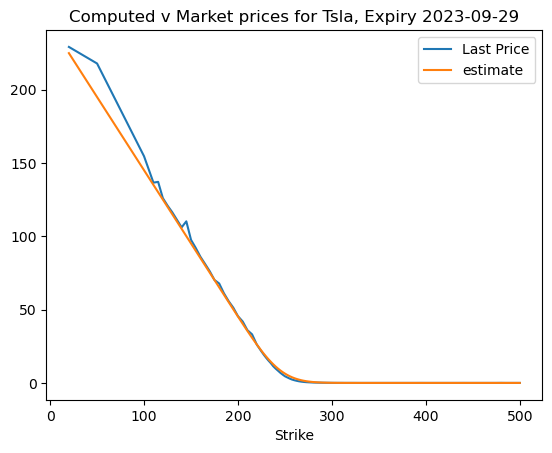

In [59]:
# plot option prices across strikes

df_estimate.plot(x='Strike',y=['Last Price','estimate'], title='Computed v Market prices for {}, Expiry {}'.format(ticker, expiration_datetime.date()))


count    9.400000e+01
mean     6.746198e+13
std      4.216247e+14
min     -5.569229e+01
25%     -7.428709e+00
50%      2.387530e+00
75%      2.111646e+06
max      3.805186e+15
Name: estimate_error, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'estimate error across strikes'}, xlabel='Strike'>

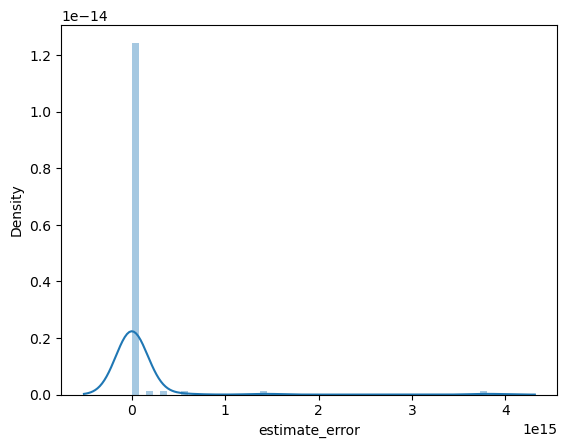

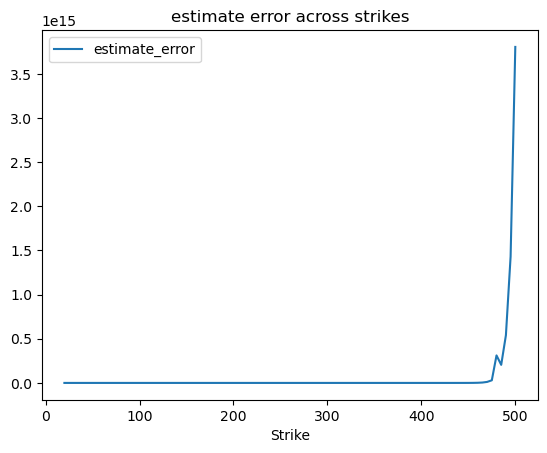

In [60]:
df_estimate['estimate_error'] = ((df_estimate['Last Price'] - df_estimate['estimate'])/df_estimate['estimate'])*100
ax = sns.distplot(df_estimate['estimate_error'])
print(df_estimate['estimate_error'].describe())

# across strikes, the median error is 34%, but there is a huge spread and outliers, 
# which mainly seem to be due to the higher strikes being very close to 0.

# plot the error across strikes

df_estimate.plot(x='Strike',y='estimate_error',title='estimate error across strikes')

In [61]:
# what is a measure of error?
# MSE: average of the sum of squared errors

mse = np.sum((df_estimate['Last Price'] - df_estimate['estimate'])**2) / df_estimate.shape[0]
rmse = np.sqrt(mse)

print(mse, rmse)
# could also try MAD

9.107476291123916 3.0178595545723987


In [62]:
# examine outliers

df_estimate[df_estimate['estimate_error'].abs() > 1]

# the model tends to undervalue puts especially at high strikes (deep out of the money).

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate,estimate_error
0,TSLA230929C00020000,2023-09-22 1:53PM EDT,20.0,229.15,222.50,227.80,-10.59,-4.42%,2,3,796.09%,2.249117e+02,1.884417e+00
1,TSLA230929C00050000,2023-09-20 10:15AM EDT,50.0,217.85,192.55,197.80,0.00,-,49,56,505.47%,1.949593e+02,1.174127e+01
2,TSLA230929C00100000,2023-09-22 12:40PM EDT,100.0,154.58,142.60,147.95,-3.53,-2.23%,1,57,304.69%,1.450386e+02,6.578518e+00
3,TSLA230929C00110000,2023-09-22 2:57PM EDT,110.0,136.59,134.15,135.70,-9.89,-6.75%,31,2,210.94%,1.350545e+02,1.136971e+00
4,TSLA230929C00115000,2023-08-29 11:30AM EDT,115.0,137.12,127.65,132.85,0.00,-,1,14,258.20%,1.300624e+02,5.426319e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,TSLA230929C00480000,2023-08-29 12:25PM EDT,480.0,0.04,0.00,0.01,0.00,-,-,33,140.63%,1.284286e-14,3.114572e+14
90,TSLA230929C00485000,2023-09-06 10:09AM EDT,485.0,0.01,0.00,0.01,0.00,-,8,46,143.75%,4.884874e-15,2.047136e+14
91,TSLA230929C00490000,2023-09-18 2:32PM EDT,490.0,0.01,0.00,0.01,0.00,-,3,8,143.75%,1.850765e-15,5.403171e+14
92,TSLA230929C00495000,2023-09-15 9:48AM EDT,495.0,0.01,0.00,0.01,0.00,-,1,110,146.88%,6.986279e-16,1.431377e+15


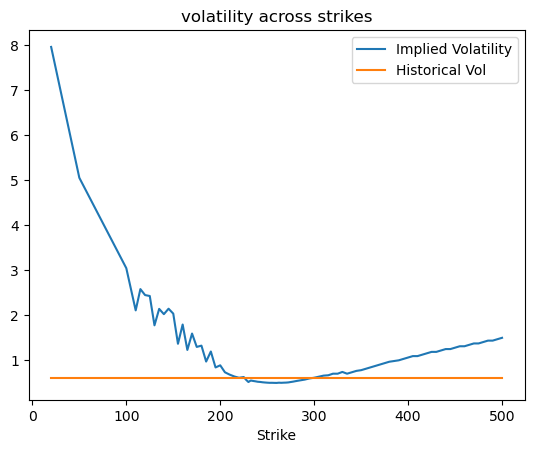

In [63]:
# how accurate are our vol estimates?

df_estimate['Implied Volatility'] = df_estimate['Implied Volatility'].str.replace(',','').str.slice(stop=-1).astype('float') / 100

df_estimate['Historical Vol'] = sigma
ax = df_estimate.plot(x='Strike',y=['Implied Volatility','Historical Vol'],title='volatility across strikes')

<AxesSubplot:title={'center':'volume and open interest'}, xlabel='Strike'>

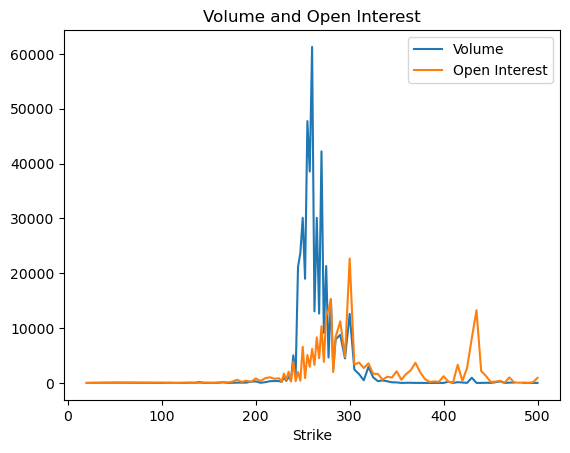

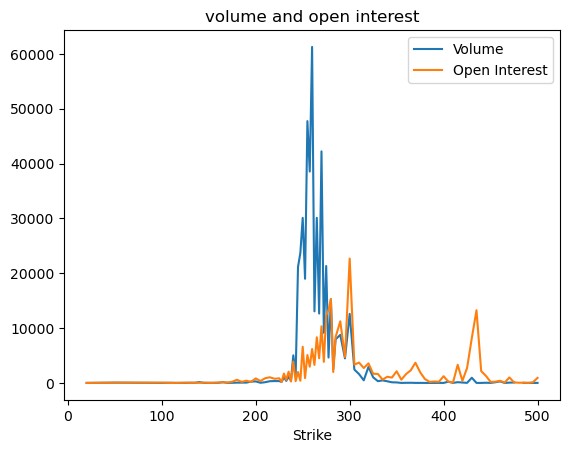

In [77]:
df_estimate['Volume'] = df_estimate['Volume'].replace(to_replace='-',value=0)
# Remove commas from 'Volume' and 'Open Interest' columns and convert to integers
df_estimate['Volume'] = df_estimate['Volume'].replace(',', '', regex=True).astype(float)


# Now you can plot the data
df_estimate.plot(x='Strike', y=['Volume', 'Open Interest'], title='Volume and Open Interest')

df_estimate['Volume'] = df_estimate['Volume'].astype(float)

df_estimate['Open Interest'] = df_estimate['Open Interest'].replace(to_replace='-',value=0)
df_estimate['Open Interest'] = df_estimate['Open Interest'].replace(',', '', regex=True).astype(float)
df_estimate['Open Interest'] = df_estimate['Open Interest'].astype(float)

df_estimate.plot(x='Strike',y=['Volume','Open Interest'],title='volume and open interest')

count       94.000000
mean      2436.372340
std       3969.728801
min          2.000000
25%        170.500000
50%        833.000000
75%       2907.250000
max      22681.000000
Name: Open Interest, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


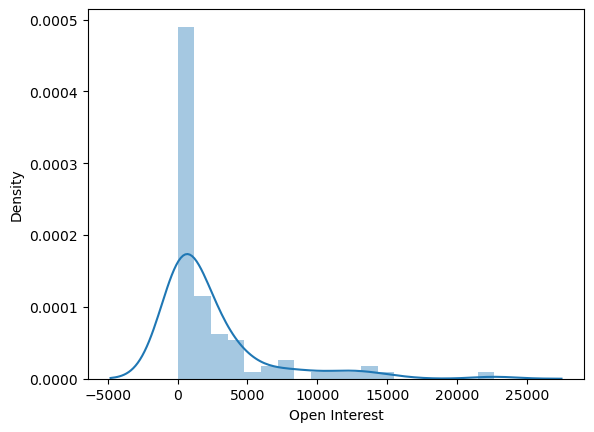

In [78]:
sns.distplot(df_estimate['Open Interest'])
print(df_estimate['Open Interest'].describe())

count    9.000000e+01
mean     6.445677e+13
std      4.278810e+14
min     -5.569229e+01
25%     -9.820082e+00
50%      2.387530e+00
75%      2.111646e+06
max      3.805186e+15
Name: estimate_error, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Option prices for Tsla, Expiry 2023-09-29 (Filtered Strikes)'}, xlabel='Strike'>

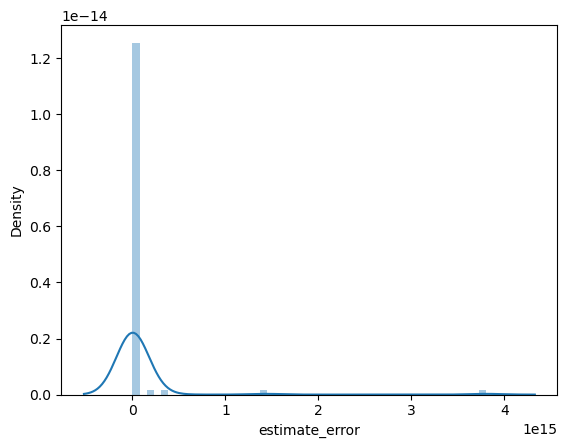

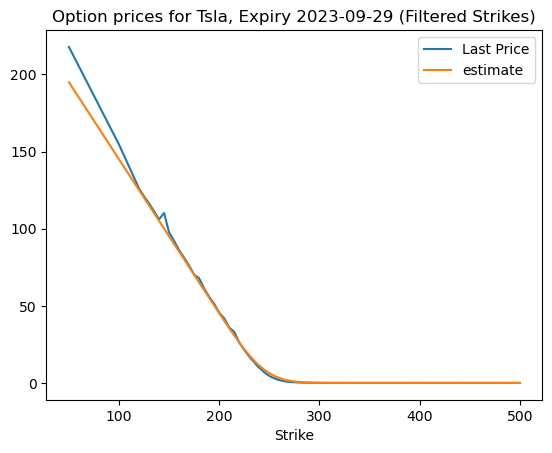

In [79]:
# filter out low volume options

# lower_bound, upper_bound = cur_stock_price * .5, cur_stock_price * 1.5
# price_estimate_filtered = df_estimate[(df_estimate['Strike'] > lower_bound) & (df_estimate['Strike'] < upper_bound)].reset_index()

price_estimate_filtered = df_estimate[(df_estimate['Open Interest'] > 15)].reset_index()
ax = sns.distplot(price_estimate_filtered['estimate_error'])
print(price_estimate_filtered['estimate_error'].describe())

price_estimate_filtered.plot(x='Strike',y=['Last Price','estimate'], title='Option prices for {}, Expiry {} (Filtered Strikes)'.format(ticker, expiration_datetime.date()))

In [80]:
# if we use implied vol instead of historical vol, our estimate should improve

def calculate_prices_across_strikes(options_df, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type):

    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
    list_estimates = []
    estimates_with_implied = []

    strike_start_idx, strike_end_idx = 0, options_df.shape[0]

    # run BSM for different strikes
    for x in range(strike_start_idx,strike_end_idx):
#         print(options_df['Strike'][x])
        value_s = black_scholes(S = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = sigma,
                                option_type = option_type)
        list_estimates.append(value_s)
    for x in range(strike_start_idx,strike_end_idx):
#         print(options_df['Strike'][x])
        value_s = black_scholes(S = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = options_df['Implied Volatility'][x],
                                option_type = option_type)
        estimates_with_implied.append(value_s)

    # merge the real and computed dataframes to compare results
    df_estimate = options_df[['Strike','Last Price']]
    df_estimate['estimate'] = list_estimates
    df_estimate['estimate_with_implied'] = estimates_with_implied

    return df_estimate

In [82]:
option_type='call'

cur_stock_price: 244.880005, time to expiration: 0.01984126984126984, rfr: 0.08, vol: 0.6123132632279679


C:\Users\hp\AppData\Local\Temp\ipykernel_13724\847766816.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_estimate['estimate'] = list_estimates
C:\Users\hp\AppData\Local\Temp\ipykernel_13724\847766816.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_estimate['estimate_with_implied'] = estimates_with_implied


<AxesSubplot:title={'center':'Option Prices for Tsla, Expiry 2023-09-29, with Implied Vol'}, xlabel='Strike'>

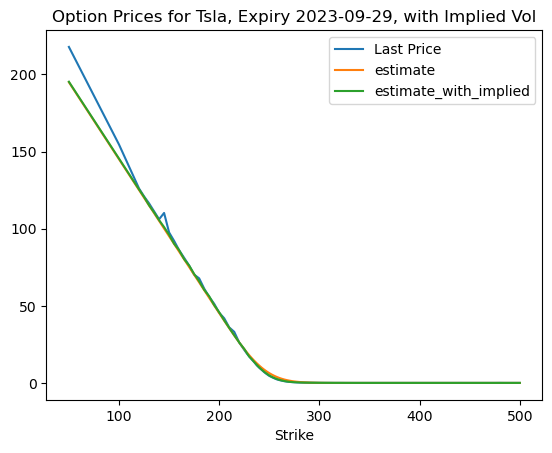

In [83]:
df_estimate_european = calculate_prices_across_strikes(price_estimate_filtered, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type)
df_estimate_european.plot(x='Strike',y=['Last Price','estimate','estimate_with_implied'], title='Option Prices for {}, Expiry {}, with Implied Vol'.format(ticker, expiration_datetime.date()))


count     90.000000
mean      27.898208
std       71.480657
min      -49.583394
25%       -4.090691
50%        1.076053
75%       51.797977
max      555.907136
Name: estimate_with_implied_error, dtype: float64
7.755565646041063 2.7848816215489416


C:\Users\hp\AppData\Local\Temp\ipykernel_13724\3519745209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_estimate_european['estimate_with_implied_error'] = ((df_estimate_european['Last Price'] - df_estimate_european['estimate_with_implied'])/df_estimate_european['estimate_with_implied'])*100
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


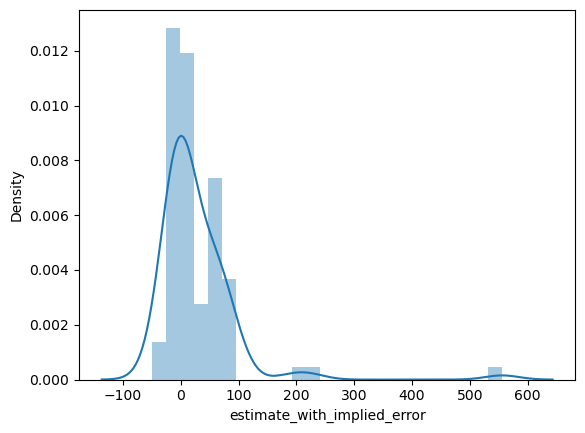

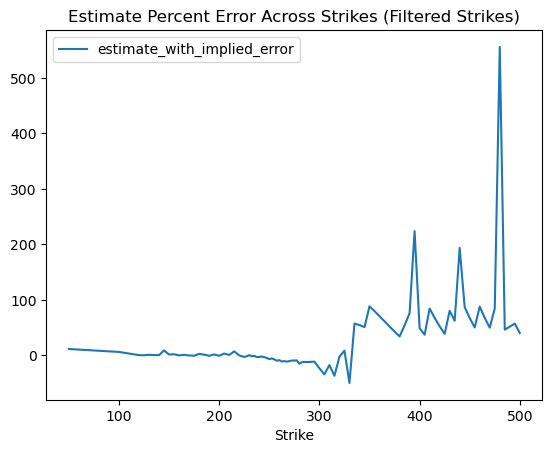

In [84]:
df_estimate_european['estimate_with_implied_error'] = ((df_estimate_european['Last Price'] - df_estimate_european['estimate_with_implied'])/df_estimate_european['estimate_with_implied'])*100
ax = sns.distplot(df_estimate_european['estimate_with_implied_error'])
print(df_estimate_european['estimate_with_implied_error'].describe())
df_estimate_european.plot(x='Strike',y='estimate_with_implied_error',title='Estimate Percent Error Across Strikes (Filtered Strikes)')

mse = np.sum((df_estimate_european['Last Price'] - df_estimate_european['estimate_with_implied'])**2) / df_estimate_european.shape[0]
rmse = np.sqrt(mse)

print(mse, rmse)

In [86]:
pip install functions

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for functions: filename=functions-0.7.0-py3-none-any.whl size=3037 sha256=b9f440914a08f2df1b2af41be6c8fcf1d32fc9955035e0bea7a85ea15ee99cd4
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\63\ca\d9\73ec659d2990d31babc19c341176ab5effbd06aeb744dce6b1
Successfully built functions
Note: you may need to restart the kernel to use updated packages.


In [105]:
import numpy as np
import scipy as scp
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.sparse.linalg import splu
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from time import time
import scipy.stats as ss


class BS_pricer():
    """
    Closed Formula.
    Monte Carlo.
    Finite-difference Black-Scholes PDE:
     df/dt + r df/dx + 1/2 sigma^2 d^f/dx^2 -rf = 0
    """
    def __init__(self, Option_info, Process_info ):
        """
        Process_info:  of type Diffusion_process. It contains (r,mu, sig) i.e.  interest rate, drift coefficient, diffusion coefficient
    
        Option_info:  of type Option_param. It contains (S0,K,T) i.e. current price, strike, maturity in years
        """
        self.r = Process_info.r           # interest rate
        self.sig = Process_info.sig       # diffusion coefficient
        self.S0 = Option_info.S0          # current price
        self.K = Option_info.K            # strike
        self.T = Option_info.T            # maturity in years
        self.exp_RV = Process_info.exp_RV # function to generate solution of GBM
        
        self.price = 0
        self.S_vec = None
        self.price_vec = None
        self.mesh = None
        self.exercise = Option_info.exercise
        self.payoff = Option_info.payoff
        
        
    def payoff_f(self, S):
        if self.payoff == "call":
            Payoff = np.maximum( S - self.K, 0 )
        elif self.payoff == "put":    
            Payoff = np.maximum( self.K - S, 0 )  
        return Payoff
        
    
    @staticmethod
    def BlackScholes(payoff='call', S0=100., K=100., T=1., r=0.1, sigma=0.2 ):
        """ Black Scholes closed formula:
            payoff: call or put.
            S0: float.    initial stock/index level.
            K: float strike price.
            T: float maturity (in year fractions).  
            r: float constant risk-free short rate.
            sigma: volatility factor in diffusion term. """
   
        d1 = (np.log(S0/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S0/K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))

        if payoff=="call":
            return S0 * ss.norm.cdf( d1 ) - K * np.exp(-r * T) * ss.norm.cdf( d2 )
        elif payoff=="put":
            return K * np.exp(-r * T) * ss.norm.cdf( -d2 ) - S0 * ss.norm.cdf( -d1 )
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")
    
    
    @staticmethod        
    def vega(sigma, S0, K, T, r):
        """ BS vega: derivative of the price with respect to the volatility """
        d1 = (np.log(S0/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        return S0 * np.sqrt(T) * ss.norm.pdf(d1)
    
    
    def closed_formula(self):
        """ 
        Black Scholes closed formula:
        """
        d1 = (np.log(self.S0/self.K) + (self.r + self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))
        d2 = (np.log(self.S0/self.K) + (self.r - self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))

        if self.payoff=="call":
            return self.S0 * ss.norm.cdf( d1 ) - self.K * np.exp(-self.r * self.T) * ss.norm.cdf( d2 )
        elif self.payoff=="put":
            return self.K * np.exp(-self.r * self.T) * ss.norm.cdf( -d2 ) - self.S0 * ss.norm.cdf( -d1 )
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")
    
    
    
    def Fourier_inversion(self):
        """
        Price obtained by inversion of the characteristic function
        """
        k = np.log(self.K/self.S0)
        cf_GBM = partial(cf_normal, mu=( self.r - 0.5 * self.sig**2 )*self.T, sig=self.sig*np.sqrt(self.T))  # function binding
        
        if self.payoff == "call":
            call = self.S0 * Q1(k, cf_GBM, np.inf) - self.K * np.exp(-self.r*self.T) * Q2(k, cf_GBM, np.inf)   # pricing function
            return call
        elif self.payoff == "put":
            put = self.K * np.exp(-self.r*self.T) * (1 - Q2(k, cf_GBM, np.inf)) - self.S0 * (1-Q1(k, cf_GBM, np.inf))  # pricing function
            return put
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")
            
     
    def FFT(self, K):
        """
        FFT method. It returns a vector of prices.
        K is an array of strikes
        """
        K = np.array(K)
        cf_GBM = partial(cf_normal, mu=( self.r - 0.5 * self.sig**2 )*self.T, sig=self.sig*np.sqrt(self.T))  # function binding
        if self.payoff == "call":
            return fft_Lewis(K, self.S0, self.r, self.T, cf_GBM, interp="cubic")
        elif self.payoff == "put":    # put-call parity
            return fft_Lewis(K, self.S0, self.r, self.T, cf_GBM, interp="cubic") - self.S0 + K*np.exp(-self.r*self.T)
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")
            
            
    def IV_Lewis(self):
        """ Implied Volatility from the Lewis formula """
    
        cf_GBM = partial(cf_normal, mu=( self.r - 0.5 * self.sig**2 )*self.T, sig=self.sig*np.sqrt(self.T))  # function binding
        if self.payoff == "call":
            return IV_from_Lewis(self.K, self.S0, self.T, self.r, cf_GBM)
        elif self.payoff == "put":
            raise NotImplementedError
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")
    
        
    def MC(self, N, Err=False, Time=False):
        """
        BS Monte Carlo
        Err = return Standard Error if True
        Time = return execution time if True
        """
        t_init = time()
             
        S_T = self.exp_RV( self.S0, self.T, N )
        PayOff = self.payoff_f(S_T)
        V = scp.mean( np.exp(-self.r*self.T) * PayOff, axis=0  )
        
        if (Err == True):
            if (Time == True):
                elapsed = time()-t_init
                return V, ss.sem(np.exp(-self.r*self.T) * self.payoff_f(S_T)), elapsed
            else:
                return V, ss.sem(np.exp(-self.r*self.T) * self.payoff_f(S_T))
        else:
            if (Time == True):
                elapsed = time()-t_init
                return V, elapsed
            else:
                return V
    
    
    
    def PDE_price(self, steps, Time=False, solver="splu"):
        """
        steps = tuple with number of space steps and time steps
        payoff = "call" or "put"
        exercise = "European" or "American"
        Time = Boolean. Execution time.
        Solver = spsolve or splu or Thomas or SOR
        """
        t_init = time()
        
        Nspace = steps[0]   
        Ntime = steps[1]
        
        S_max = 6*float(self.K)                
        S_min = float(self.K)/6
        x_max = np.log(S_max)
        x_min = np.log(S_min)
        x0 = np.log(self.S0)                            # current log-price
        
        x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  
        t, dt = np.linspace(0, self.T, Ntime, retstep=True)
        
        self.S_vec = np.exp(x)        # vector of S
        Payoff = self.payoff_f(self.S_vec)

        V = np.zeros((Nspace,Ntime))
        if self.payoff == "call":
            V[:,-1] = Payoff
            V[-1,:] = np.exp(x_max) - self.K * np.exp(-self.r* t[::-1] )
            V[0,:]  = 0
        else:    
            V[:,-1] = Payoff
            V[-1,:] = 0
            V[0,:]  = Payoff[0] * np.exp(-self.r* t[::-1] )    # Instead of Payoff[0] I could use K 
                                                    # For s to 0, the limiting value is e^(-rT)(K-s)     
        
        sig2 = self.sig**2 
        dxx = dx**2
        a = ( (dt/2) * ( (self.r-0.5*sig2)/dx - sig2/dxx ) )
        b = ( 1 + dt * ( sig2/dxx + self.r ) )
        c = (-(dt/2) * ( (self.r-0.5*sig2)/dx + sig2/dxx ) )
        
        D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
            
        offset = np.zeros(Nspace-2)
        
        
        if solver == "spsolve":        
            if self.exercise=="European":        
                for i in range(Ntime-2,-1,-1):
                    offset[0] = a * V[0,i]
                    offset[-1] = c * V[-1,i]
                    V[1:-1,i] = spsolve( D, (V[1:-1,i+1] - offset) )
            elif self.exercise=="American":
                for i in range(Ntime-2,-1,-1):
                    offset[0] = a * V[0,i]
                    offset[-1] = c * V[-1,i]
                    V[1:-1,i] = np.maximum( spsolve( D, (V[1:-1,i+1] - offset) ), Payoff[1:-1])
        elif solver == "Thomas":        
            if self.exercise=="European":        
                for i in range(Ntime-2,-1,-1):
                    offset[0] = a * V[0,i]
                    offset[-1] = c * V[-1,i]
                    V[1:-1,i] = Thomas( D, (V[1:-1,i+1] - offset) )
            elif self.exercise=="American":
                for i in range(Ntime-2,-1,-1):
                    offset[0] = a * V[0,i]
                    offset[-1] = c * V[-1,i]
                    V[1:-1,i] = np.maximum( Thomas( D, (V[1:-1,i+1] - offset) ), Payoff[1:-1]) 
        elif solver == "SOR":        
            if self.exercise=="European":        
                for i in range(Ntime-2,-1,-1):
                    offset[0] = a * V[0,i]
                    offset[-1] = c * V[-1,i]
                    V[1:-1,i] = SOR( a,b,c, (V[1:-1,i+1] - offset), w=1.68, eps=1e-10, N_max=600 )
            elif self.exercise=="American":
                for i in range(Ntime-2,-1,-1):
                    offset[0] = a * V[0,i]
                    offset[-1] = c * V[-1,i]
                    V[1:-1,i] = np.maximum( SOR( a,b,c, (V[1:-1,i+1] - offset), w=1.68, eps=1e-10, N_max=600 ), Payoff[1:-1]) 
        elif solver == "splu":
            DD = splu(D)
            if self.exercise=="European":        
                for i in range(Ntime-2,-1,-1):
                    offset[0] = a * V[0,i]
                    offset[-1] = c * V[-1,i]
                    V[1:-1,i] = DD.solve( V[1:-1,i+1] - offset )
            elif self.exercise=="American":
                for i in range(Ntime-2,-1,-1):
                    offset[0] = a * V[0,i]
                    offset[-1] = c * V[-1,i]
                    V[1:-1,i] = np.maximum( DD.solve( V[1:-1,i+1] - offset ), Payoff[1:-1])
        else:
            raise ValueError("Solver is splu, spsolve, SOR or Thomas")    
        
        self.price = np.interp(x0, x, V[:,0])
        self.price_vec = V[:,0]
        self.mesh = V
        
        if (Time == True):
            elapsed = time()-t_init
            return self.price, elapsed
        else:
            return self.price
    
    
       
    def plot(self, axis=None):
        if (type(self.S_vec) != np.ndarray or type(self.price_vec) != np.ndarray):
            self.PDE_price((7000,5000))
            #print("run the PDE_price method")
            #return
        
        plt.plot(self.S_vec, self.payoff_f(self.S_vec) , color='blue',label="Payoff")
        plt.plot(self.S_vec, self.price_vec, color='red',label="BS curve")
        if (type(axis) == list):
            plt.axis(axis)
        plt.xlabel("S")
        plt.ylabel("price")
        plt.title(f"{self.exercise} - Black Scholes price")
        plt.legend()
        plt.show()
        
        
    def mesh_plt(self):
        if (type(self.S_vec) != np.ndarray or type(self.mesh) != np.ndarray):
            self.PDE_price((7000,5000))
            
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        X, Y = np.meshgrid( np.linspace(0, self.T, self.mesh.shape[1]) , self.S_vec)
        ax.plot_surface(Y, X, self.mesh, cmap=cm.ocean)
        ax.set_title(f"{self.exercise} - BS price surface")
        ax.set_xlabel("S"); ax.set_ylabel("t"); ax.set_zlabel("V")
        ax.view_init(30, -100) # this function rotates the 3d plot
        plt.show()
        
        
    def LSM(self, N=10000, paths=10000, order=2):
        """
        Longstaff-Schwartz Method for pricing American options
        
        N = number of time steps
        paths = number of generated paths
        order = order of the polynomial for the regression 
        """
        
        if self.payoff!="put":
            raise ValueError("invalid type. Set 'call' or 'put'")
        
        dt = self.T/(N-1)          # time interval
        df = np.exp(-self.r * dt)  # discount factor per time time interval
        
        X0 = np.zeros((paths,1))
        increments = ss.norm.rvs(loc=(self.r-self.sig**2/2)*dt, scale=np.sqrt(dt)*self.sig, size=(paths,N-1))
        X = np.concatenate((X0,increments), axis=1).cumsum(1)
        S = self.S0 * np.exp(X)
        
        H = np.maximum(self.K - S, 0)   # intrinsic values for put option
        V = np.zeros_like(H)            # value matrix
        V[:,-1] = H[:,-1]

        # Valuation by LS Method
        for t in range(N-2, 0, -1):
            good_paths = H[:,t] > 0    
            rg = np.polyfit( S[good_paths, t], V[good_paths, t+1] * df, 2)    # polynomial regression
            C = np.polyval( rg, S[good_paths,t] )                             # evaluation of regression  
    
            exercise = np.zeros( len(good_paths), dtype=bool)
            exercise[good_paths] = H[good_paths,t] > C
    
            V[exercise,t] = H[exercise,t]
            V[exercise,t+1:] = 0
            discount_path = (V[:,t] == 0)
            V[discount_path,t] = V[discount_path,t+1] * df
    
        V0 = np.mean(V[:,1]) * df  # 
        return V0

In [106]:
class Option_param():
    """
    Option class wants the option parameters:
    S0 = current stock price
    K = Strike price
    T = time to maturity
    v0 = (optional) spot variance 
    exercise = European or American
    """
    def __init__(self, S0=15, K=15, T=1, v0=0.04, payoff="call", exercise="European"):
        self.S0 = S0
        self.v0 = v0
        self.K = K
        self.T = T
        
        if (exercise=="European" or exercise=="American"):
            self.exercise = exercise
        else: 
            raise ValueError("invalid type. Set 'European' or 'American'")
        
        if (payoff=="call" or payoff=="put"):
            self.payoff = payoff
        else: 
            raise ValueError("invalid type. Set 'call' or 'put'")

In [109]:
import numpy as np
import scipy.stats as ss

from scipy.optimize import minimize
from statsmodels.tools.numdiff import approx_hess
import pandas as pd


class Diffusion_process():
    """
    Class for the diffusion process:
    r = risk free constant rate
    sig = constant diffusion coefficient
    mu = constant drift 
    """
    def __init__(self, r=0.1, sig=0.2, mu=0.1):
        self.r = r
        self.mu = mu
        if (sig<=0):
            raise ValueError("sig must be positive")
        else:
            self.sig = sig

    def exp_RV(self, S0, T, N):
        W = ss.norm.rvs( (self.r-0.5*self.sig**2)*T , np.sqrt(T)*self.sig, N )
        S_T = S0 * np.exp(W)
        return S_T.reshape((N,1))



In [110]:
# Longstaff Schwartz Method

def price_american(S0, K, T, r, sigma, payoff='call'):
    
    # Creates the object with the parameters of the option
    opt_param = Option_param(S0=S0, K=K, T=T, exercise="American", payoff=payoff )
    # Creates the object with the parameters of the process
    diff_param = Diffusion_process(r=r, sig=sigma)
    # Creates the pricer object
    BS = BS_pricer(opt_param, diff_param)
    
#     return BS.LSM(N=1000, paths=1000, order=2)  # Longstaff Schwartz Method
    N_space = 8000
    N_time = 5000
    return BS.PDE_price((N_space,N_time))

# def plot_american(BS, x_start, x_end, y_start, y_end):
    
#     fig = plt.figure(figsize=(9,5))
#     BS.plot([x_start,x_end,y_start,y_end])

In [111]:
# price_american(S0=100, K=100, T=1, r=0.1, sigma=0.2, payoff="put" )
# 1827.949951 1110.0 0.7817460317460317 0.08 0.38212781123440914 put
price_american(S0=1827.949951, K=1110.0, T=0.7817460317460317, r=0.08, sigma=0.38212781123440914, payoff="put" )

cur_stock_price: 244.880005, time to expiration: 0.01984126984126984, rfr: 0.08, vol: 0.6123132632279679
strike 50.0
strike 160.0
strike 210.0
strike 242.5
strike 267.5
strike 300.0
strike 350.0
strike 400.0
strike 450.0
0     1.949593e+02
10    8.513378e+01
20    3.549198e+01
30    9.830399e+00
40    1.815909e+00
50    7.708637e-02
60    1.047505e-04
70    3.286740e-08
80    4.124840e-12
dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_13724\1556287482.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_estimate['estimate'] = price_estimates


<AxesSubplot:title={'center':'Option Prices for Tsla, Expiry 2023-09-29, with Implied Vol'}, xlabel='Strike', ylabel='[estimate]'>

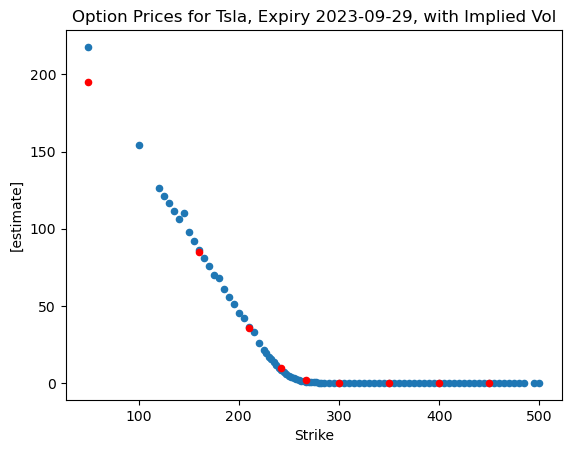

In [115]:
# if we use implied vol instead of historical vol, our estimate should improve

def calculate_prices_across_strikes_american(options_df, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type):

    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
    index = []
    list_estimates = []
#     estimates_with_implied = []

    strike_start_idx, strike_end_idx = 0, options_df.shape[0]
    step = 10

    # run BSM for different strikes
    for x in range(strike_start_idx,strike_end_idx, step):
        index.append(x)
        print('strike', options_df['Strike'][x])
        value_s = price_american(S0 = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = sigma,
                                payoff = option_type)
        list_estimates.append(value_s)
        
#         print(cur_stock_price, options_df['Strike'][x], time_to_expiration, risk_free_rate, options_df['Implied Volatility'][x], option_type)
#         value_s = price_american(S0 = cur_stock_price, 
#                                 K = options_df['Strike'][x], 
#                                 T = time_to_expiration, 
#                                 r = risk_free_rate, 
#                                 sigma = options_df['Implied Volatility'][x],
#                                 payoff = option_type)
#         estimates_with_implied.append(value_s)
    price_estimates = pd.Series(data=list_estimates, index=index)
    print(price_estimates)
    #     df_estimate['estimate_with_implied'] = estimates_with_implied
    df_estimate = options_df[['Strike','Last Price']]
    df_estimate['estimate'] = price_estimates

    return df_estimate

df_estimate_american = calculate_prices_across_strikes_american(price_estimate_filtered, cur_stock_price, time_to_expiration, risk_free_rate, sigma, option_type)
# df_estimate.plot(x='Strike',y=['Last Price','estimate','estimate_with_implied'], title='Option Prices for {}, Expiry {}, with Implied Vol'.format(ticker, expiration_datetime.date()))
# df_estimate.plot(x='Strike',y=['Last Price','estimate'], title='Option Prices for {}, Expiry {}, with Implied Vol'.format(ticker, expiration_datetime.date()))

ax1 = df_estimate_american.plot(kind='scatter', x='Strike',y=['Last Price'], title='Option Prices for {}, Expiry {}, with Implied Vol'.format(ticker, expiration_datetime.date()))
df_estimate_american.plot(kind='scatter', x='Strike',y=['estimate'], ax=ax1, color='r')

C:\Users\hp\AppData\Local\Temp\ipykernel_13724\3947141938.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_estimate_american['european_estimate'] = df_estimate_european['estimate']
C:\Users\hp\AppData\Local\Temp\ipykernel_13724\3947141938.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_estimate_american['european_estimate_with_implied'] = df_estimate_european['estimate_with_implied']


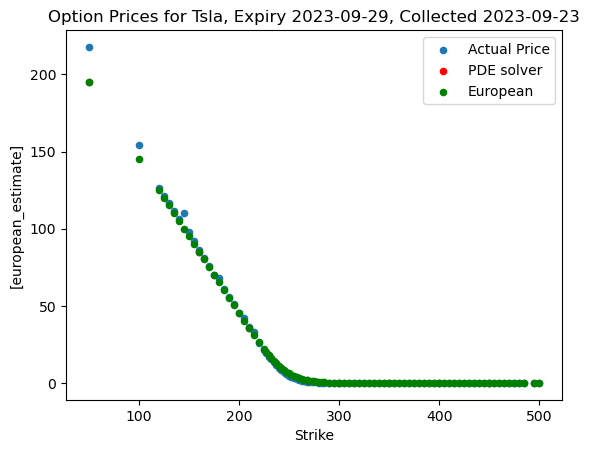

In [116]:
# compare with european

df_estimate_american['european_estimate'] = df_estimate_european['estimate']
df_estimate_american['european_estimate_with_implied'] = df_estimate_european['estimate_with_implied']

ax1 = df_estimate_american.plot(kind='scatter', x='Strike',y=['Last Price'], label='Actual Price')
df_estimate_american.plot(kind='scatter', x='Strike',y=['estimate'], ax=ax1, color='r', label='PDE solver')
df_estimate_american.plot(kind='scatter', x='Strike',y=['european_estimate'], ax=ax1, color='g', label='European')
# df_estimate.plot(kind='scatter', x='Strike',y=['estimate'], ax=ax1, color='r')
ax1.set_title('Option Prices for {}, Expiry {}, Collected {}'.format(ticker, expiration_datetime.date(), datetime.now().date()))
ax1.legend()

In [117]:
# binomial tree
import math

sigma = .2
rfr = .02
delta_t = 1

u = math.exp(sigma * math.sqrt(delta_t))
d = math.exp(-sigma * math.sqrt(delta_t))
print('u and d:',u,d)

# a = math.exp(rfr * delta_t)
a = math.exp((rfr - .01) * delta_t)
p = (a - d)/(u - d)

print('p', p)

u and d: 1.2214027581601699 0.8187307530779818
p 0.47512469600943963


In [118]:
# N period binomial tree model

def price_option_european(S_0, u, d, K, option_type: str, num_periods: int):
    
    if num_periods == 0:
        if option_type == 'call':
            return max(S_0-K, 0)
        elif option_type == 'put':
            return max(K-S_0, 0)
    else:
        S_u = S_0 * u
        S_d = S_0 * d
        
        f_u = price_option_european(S_0 * u,u,d,K,option_type,num_periods-1)
        f_d = price_option_european(S_0 * d,u,d,K,option_type,num_periods-1)
        
#         print('f_u and f_d:', f_u, f_d)

        return math.exp(-rfr*delta_t) * (p*f_u + (1-p)*f_d)

S_0 = 200
K = 200
option_type = 'put'

for i in range(5):
    price = price_option_european(S_0, u, d, K, option_type, num_periods=i)
    print('price',price)
  

price 0
price 18.65195571686643
price 17.452716560268637
price 25.695678025946652
price 24.44307753439426


In [119]:
def price_option_american(S_0, u, d, K, option_type: str, num_periods: int):
    
    if num_periods == 0:
        if option_type == 'call':
            return max(S_0-K, 0)
        elif option_type == 'put':
            return max(K-S_0, 0)
    else:
        S_u = S_0 * u
        S_d = S_0 * d
        
        f_u = price_option_american(S_0 * u,u,d,K,option_type,num_periods-1)
        f_d = price_option_american(S_0 * d,u,d,K,option_type,num_periods-1)
        
        if option_type == 'call':
            f_u_early = max(S_u-K, 0)
            f_d_early = max(S_d-K, 0)
        elif option_type == 'put':
            f_u_early = max(K-S_u, 0)
            f_d_early = max(K-S_d, 0)
#         print('f_u,f_d,f_u_early,f_d_early:',f_u,f_d,f_u_early,f_d_early)
        f_u = max(f_u,f_u_early)
        f_d = max(f_u,f_d_early)
        
#         print('f_u and f_d:', f_u, f_d)

        return math.exp(-rfr*delta_t) * (p*f_u + (1-p)*f_d)


In [120]:
S_0 = 200
K = 200
option_type = 'put'

for i in range(5):
    price = price_option_american(S_0, u, d, K, option_type, num_periods=i)
    print('price',price)

price 0
price 18.65195571686643
price 18.65195571686643
price 18.65195571686643
price 18.65195571686643
